In [1]:
import numpy as np
# from examples.simple_train_loop import get_data_loader

In [2]:
import h5py

f = h5py.File("datasets/lift/ph/low_dim_v141.hdf5", "r")
# Print the top-level keys in the file
print("Top level keys in the HDF5 file:")
print(list(f.keys()))
print(len(f['data'].keys()))


Top level keys in the HDF5 file:
['data', 'mask']
200


In [3]:
demo = f['data']['demo_0']
print(demo.keys())
print(demo.get('obs').keys())
# print(states.shape)


<KeysViewHDF5 ['actions', 'dones', 'next_obs', 'obs', 'rewards', 'states']>
<KeysViewHDF5 ['object', 'robot0_eef_pos', 'robot0_eef_quat', 'robot0_eef_vel_ang', 'robot0_eef_vel_lin', 'robot0_gripper_qpos', 'robot0_gripper_qvel', 'robot0_joint_pos', 'robot0_joint_pos_cos', 'robot0_joint_pos_sin', 'robot0_joint_vel']>


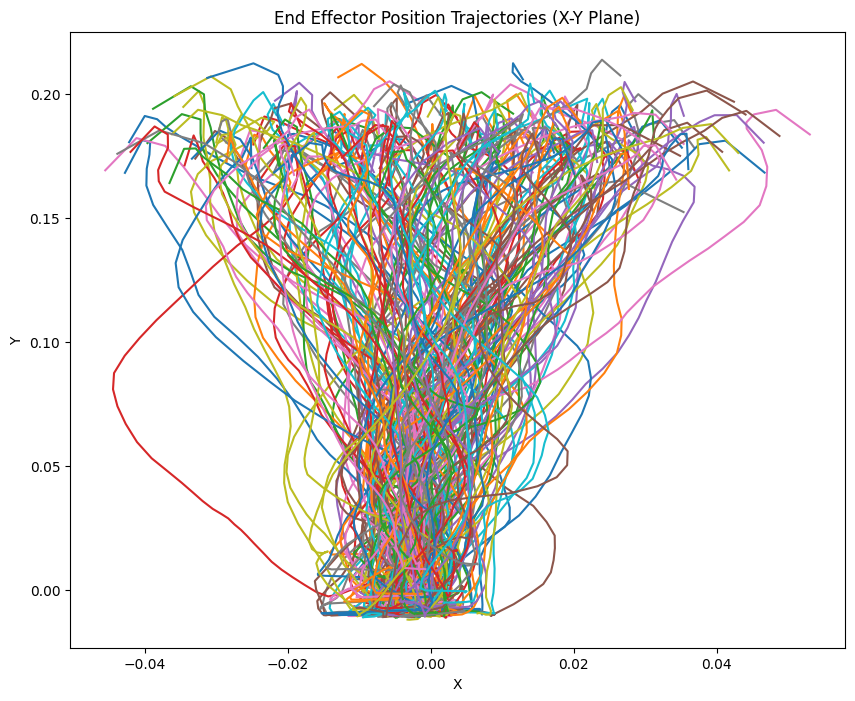

In [4]:
from matplotlib import pyplot as plt
# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Plot trajectories for 10 demonstrations with different colors
for i in range(200):
    obs_trajectory = f['data'][f'demo_{i}'].get('obs').get('robot0_eef_pos')[()]
    object_state = f['data'][f'demo_{i}'].get('obs').get('object')[()]
    # print(object_state[0])
    ax.plot(object_state[:, -2], object_state[:, -1], label=f'Demo {i}')

# ax.scatter([0, 0], [0, 0], color='red', marker='*', s=200, label='Start')
ax.set_xlabel('X')
ax.set_ylabel('Y')
# ax.legend()
ax.set_title('End Effector Position Trajectories (X-Y Plane)')

plt.show()


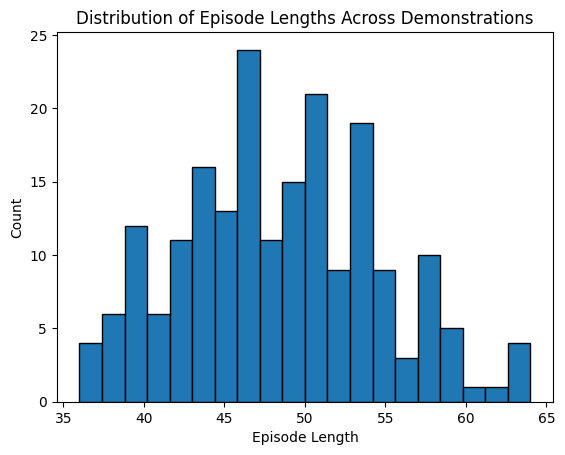

In [5]:
epi_length = []

for i in range(200):
    obs_trajectory = f['data'][f'demo_{i}'].get('obs').get('robot0_eef_pos')[()]
    epi_length.append(obs_trajectory.shape[0])

epi_length = np.array(epi_length)
plt.hist(epi_length, bins=20, edgecolor='black')
plt.xlabel('Episode Length')
plt.ylabel('Count')
plt.title('Distribution of Episode Lengths Across Demonstrations')
plt.show()


In [6]:
num_demos = 200

max_attention = -1e10
max_attention_idx = 0
min_attention = 1e10
min_attention_idx = 0

def get_attention(action_trajectory, state_trajectory, alpha, dt=0.05):
    assert action_trajectory.shape[0] == state_trajectory.shape[0]

    temporal_attention = (np.linalg.norm(action_trajectory[:-1, :-1] - action_trajectory[1:, :-1], axis=1)/dt)**2
    

    spatial_attention = (np.linalg.norm(action_trajectory[:1] - action_trajectory[1:], axis=1)/np.linalg.norm(state_trajectory[:1] - state_trajectory[1:], axis=1))**2

    dxdt = np.sqrt(np.sum((state_trajectory[1:] - state_trajectory[:-1])**2, axis=1) + dt**2)
    
    attention = ((alpha * spatial_attention + (1-alpha) * temporal_attention) * dxdt).mean()
    return attention

attention_lst = []
for i in range(num_demos):
    action_trajectory = f['data'][f'demo_{i}'].get('actions')[()]
    state_trajectory = f['data'][f'demo_{i}'].get('obs').get('object')[()]
    attention = get_attention(action_trajectory, state_trajectory, alpha=0.0)
    attention_lst.append(attention)
    if attention > max_attention:
        max_attention = attention
        max_attention_idx = i
    if attention < min_attention:
        min_attention = attention
        min_attention_idx = i

attention_lst = np.array(attention_lst)

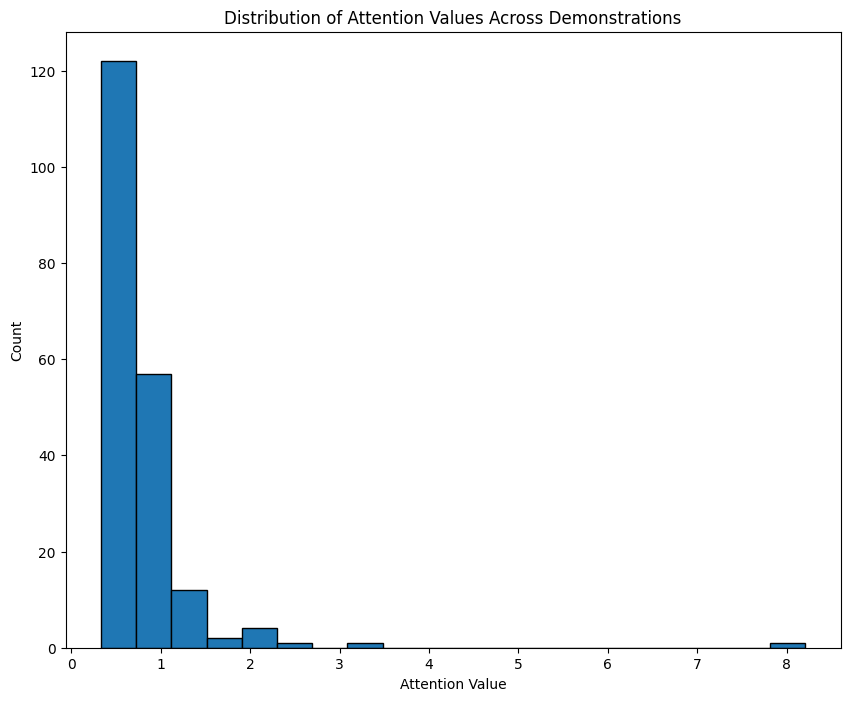

In [7]:
# Plot histogram of attention values
plt.figure(figsize=(10, 8))
plt.hist(attention_lst, bins=20, edgecolor='black')
plt.xlabel('Attention Value')
plt.ylabel('Count')
plt.title('Distribution of Attention Values Across Demonstrations')
plt.show()

In [8]:
print(f"Max attention: {max_attention}, Index: {max_attention_idx}")
print(f"Min attention: {min_attention}, Index: {min_attention_idx}")

Max attention: 8.209634730575884, Index: 156
Min attention: 0.3303824446986532, Index: 83


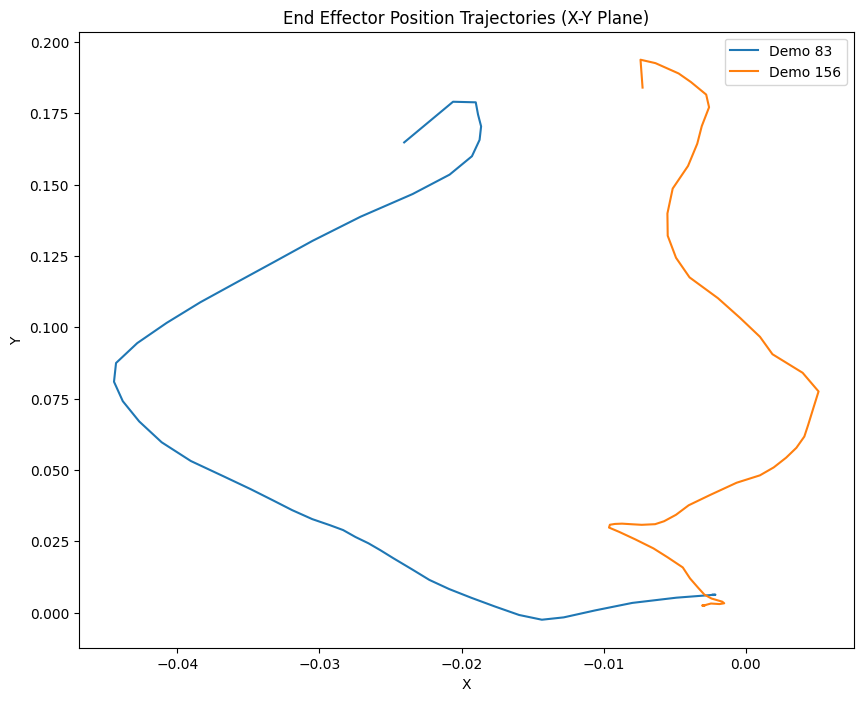

In [9]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

# Plot trajectories for 10 demonstrations with different colors
for i in [min_attention_idx, max_attention_idx]:
    object_state = f['data'][f'demo_{i}'].get('obs').get('object')[()]
    # print(object_state[0])
    ax.plot(object_state[:, -2], object_state[:, -1], label=f'Demo {i}')

# ax.scatter([0, 0], [0, 0], color='red', marker='*', s=200, label='Start')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.set_title('End Effector Position Trajectories (X-Y Plane)')

plt.show()

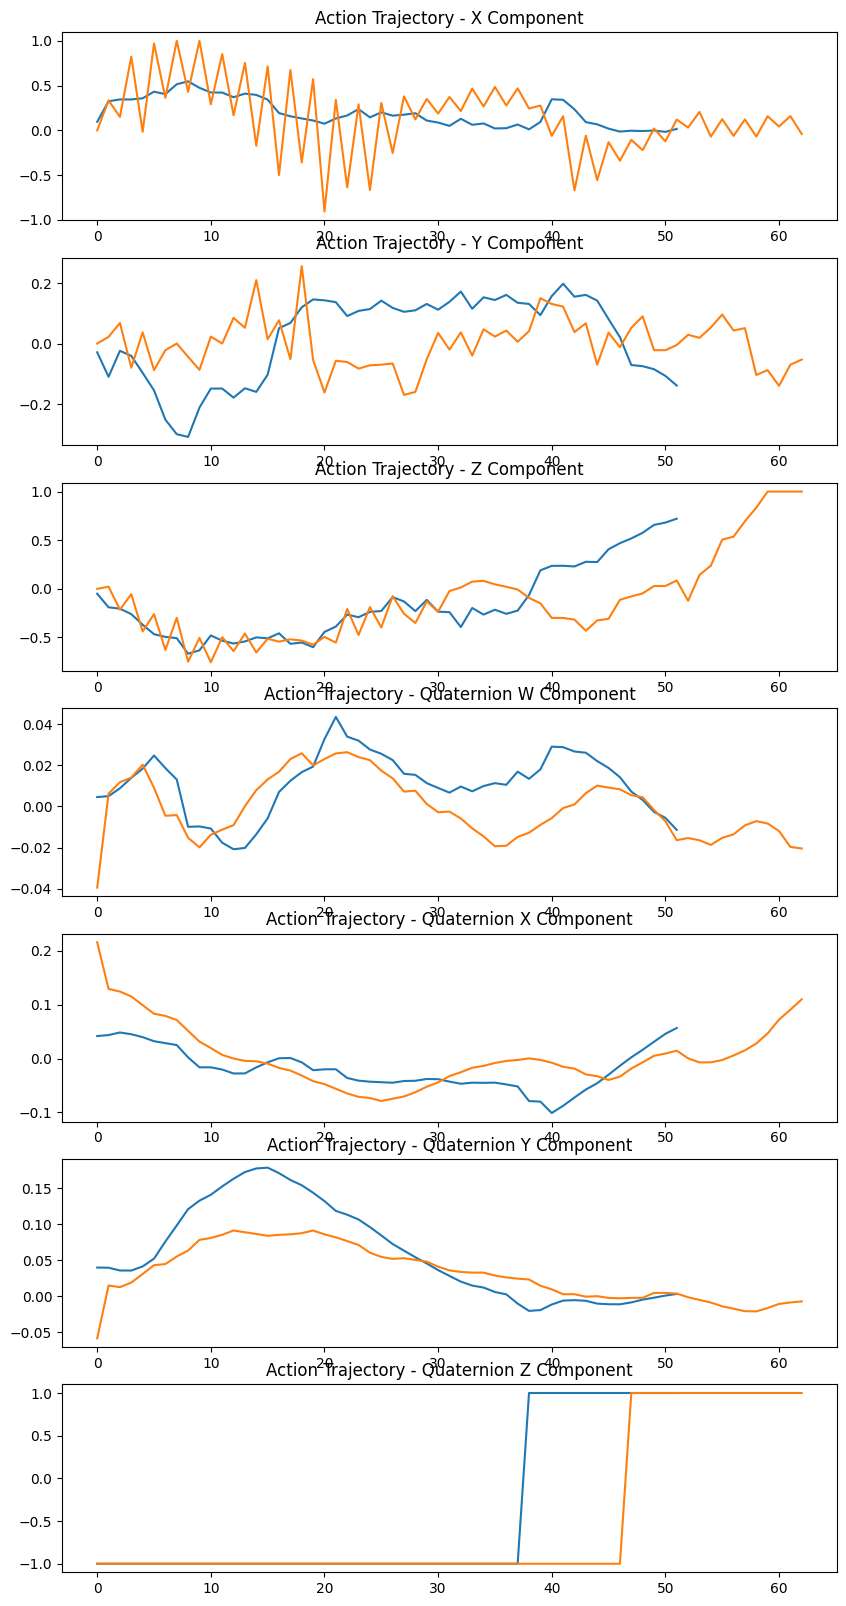

In [10]:
max_action_trajectory = f['data'][f'demo_{max_attention_idx}'].get('actions')[()]
min_action_trajectory = f['data'][f'demo_{min_attention_idx}'].get('actions')[()]
fig = plt.figure(figsize=(10, 20))
plt.subplot(7, 1, 1)
plt.plot(min_action_trajectory[:, 0])
plt.plot(max_action_trajectory[:, 0])
plt.title('Action Trajectory - X Component')
plt.subplot(7, 1, 2) 
plt.plot(min_action_trajectory[:, 1])
plt.plot(max_action_trajectory[:, 1])
plt.title('Action Trajectory - Y Component')
plt.subplot(7, 1, 3)
plt.plot(min_action_trajectory[:, 2])
plt.plot(max_action_trajectory[:, 2])
plt.title('Action Trajectory - Z Component')
plt.subplot(7, 1, 4)
plt.plot(min_action_trajectory[:, 3])
plt.plot(max_action_trajectory[:, 3])
plt.title('Action Trajectory - Quaternion W Component')
plt.subplot(7, 1, 5)
plt.plot(min_action_trajectory[:, 4])
plt.plot(max_action_trajectory[:, 4])
plt.title('Action Trajectory - Quaternion X Component')
plt.subplot(7, 1, 6)
plt.plot(min_action_trajectory[:, 5])
plt.plot(max_action_trajectory[:, 5])
plt.title('Action Trajectory - Quaternion Y Component')
plt.subplot(7, 1, 7)
plt.plot(min_action_trajectory[:, 6])
plt.plot(max_action_trajectory[:, 6])
plt.title('Action Trajectory - Quaternion Z Component')
plt.show()




In [11]:
# Sort episodes by attention values
attention_values = np.array([attention_lst[i] for i in range(len(attention_lst))])
sorted_indices = np.argsort(attention_values)
split_idx = len(sorted_indices) // 2

# Randomly select 1/10 of indices for validation set
low_valid_size = len(sorted_indices[:split_idx]) // 10
high_valid_size = len(sorted_indices[split_idx:]) // 10

# For low attention indices
low_valid_idx = np.random.choice(sorted_indices[:split_idx], size=low_valid_size, replace=False)
low_train_idx = np.array([idx for idx in sorted_indices[:split_idx] if idx not in low_valid_idx])

# For high attention indices  
high_valid_idx = np.random.choice(sorted_indices[split_idx:], size=high_valid_size, replace=False)
high_train_idx = np.array([idx for idx in sorted_indices[split_idx:] if idx not in high_valid_idx])

# Create the final string lists
train_low_att_indices = [f'demo_{i}' for i in low_train_idx]
valid_low_att_indices = [f'demo_{i}' for i in low_valid_idx]
train_high_att_indices = [f'demo_{i}' for i in high_train_idx]
valid_high_att_indices = [f'demo_{i}' for i in high_valid_idx]

# Keep original indices for reference
low_att_indices = [f'demo_{i}' for i in sorted_indices[:split_idx]]
high_att_indices = [f'demo_{i}' for i in sorted_indices[split_idx:]]

fw = h5py.File("datasets/lift/ph/low_dim_v141_att_mask_included.hdf5", "w")

fw.copy(f['data'], fw)

fw.copy(f['mask'], fw)

fw['mask'].create_dataset('low_att',(len(low_att_indices), ), data=low_att_indices, dtype="|S8")
fw['mask'].create_dataset('high_att',(len(high_att_indices), ), data=high_att_indices, dtype="|S8")

fw['mask'].create_dataset('low_att_train',(len(train_low_att_indices), ), data=train_low_att_indices, dtype="|S8")
fw['mask'].create_dataset('high_att_train',(len(train_high_att_indices), ), data=train_high_att_indices, dtype="|S8")

fw['mask'].create_dataset('low_att_valid',(len(valid_low_att_indices), ), data=valid_low_att_indices, dtype="|S8")
fw['mask'].create_dataset('high_att_valid',(len(valid_high_att_indices), ), data=valid_high_att_indices, dtype="|S8")

fw.close()
f.close()


# # Create new HDF5 files
# with h5py.File('low_dim_v141_low_att.hdf5', 'w') as flow, \
#      h5py.File('low_dim_v141_high_att.hdf5', 'w') as fhigh:
    
#     # Create data groups
#     flow.create_group('data')
#     fhigh.create_group('data')
    
#     # Create mask groups 
#     flow.create_group('mask')
#     fhigh.create_group('mask')

#     flow['data'].attrs['env_args'] = f['data'].attrs['env_args']
#     flow['data'].attrs['total'] = f['data'].attrs['total']
#     fhigh['data'].attrs['env_args'] = f['data'].attrs['env_args']
#     fhigh['data'].attrs['total'] = f['data'].attrs['total']
#     # Copy episodes with lower attention values
#     for idx in sorted_indices[:split_idx]:
#         print(idx)
#         demo_name = f'demo_{idx}'
#         # Copy data
#         flow.copy(f['data'][demo_name], flow['data'])
#         # Copy corresponding mask if exists
#         if demo_name in f['mask']:
#             flow.copy(f['mask'][demo_name], flow['mask'])
    
#     # Copy episodes with higher attention values  
#     for idx in sorted_indices[split_idx:]:
#         print(idx)
#         demo_name = f'demo_{idx}'
#         # Copy data
#         fhigh.copy(f['data'][demo_name], fhigh['data'])
#         # Copy corresponding mask if exists
#         if demo_name in f['mask']:
#             fhigh.copy(f['mask'][demo_name], fhigh['mask'])

# print(f"Created low attention file with {len(sorted_indices[:split_idx])} episodes")
# print(f"Created high attention file with {len(sorted_indices[split_idx:])} episodes")


In [12]:
print(low_att_indices)

['demo_83', 'demo_122', 'demo_32', 'demo_13', 'demo_120', 'demo_1', 'demo_22', 'demo_61', 'demo_149', 'demo_168', 'demo_143', 'demo_176', 'demo_179', 'demo_126', 'demo_96', 'demo_10', 'demo_107', 'demo_181', 'demo_106', 'demo_47', 'demo_21', 'demo_5', 'demo_97', 'demo_146', 'demo_33', 'demo_52', 'demo_19', 'demo_30', 'demo_114', 'demo_152', 'demo_136', 'demo_29', 'demo_116', 'demo_24', 'demo_92', 'demo_180', 'demo_102', 'demo_8', 'demo_35', 'demo_55', 'demo_170', 'demo_26', 'demo_14', 'demo_44', 'demo_2', 'demo_34', 'demo_198', 'demo_42', 'demo_163', 'demo_167', 'demo_20', 'demo_174', 'demo_124', 'demo_28', 'demo_183', 'demo_172', 'demo_128', 'demo_23', 'demo_119', 'demo_137', 'demo_177', 'demo_117', 'demo_186', 'demo_150', 'demo_184', 'demo_25', 'demo_46', 'demo_132', 'demo_127', 'demo_27', 'demo_129', 'demo_160', 'demo_31', 'demo_118', 'demo_123', 'demo_173', 'demo_49', 'demo_141', 'demo_103', 'demo_16', 'demo_148', 'demo_62', 'demo_145', 'demo_38', 'demo_115', 'demo_93', 'demo_18', 

In [14]:
fw = h5py.File("datasets/lift/ph/low_dim_v141_att_mask_included.hdf5", "r")
print(fw['mask'].keys())
fw.close()

<KeysViewHDF5 ['20_percent', '20_percent_train', '20_percent_valid', '50_percent', '50_percent_train', '50_percent_valid', 'high_att', 'high_att_train', 'high_att_valid', 'low_att', 'low_att_train', 'low_att_valid', 'train', 'valid']>


In [ ]:
## Convert dataset into discretized dataset with discretize_ratio 2, 4
f = h5py.File("datasets/lift/ph/low_dim_v141.hdf5", "r")
# 1. Discretize the dataset
# 2. Assign the discretized dataset to a corresponding key
# 3. Save the mask
# 4. Don't forget to divide the mask by high low attention

In [4]:
num_demos = len(f['data'].keys())



200
